In [185]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.fftpack import fft
from datetime import datetime, timedelta
import time
import numpy.polynomial.polynomial as poly
import pywt
from scipy.signal import savgol_filter
from matplotlib import gridspec
from scipy.signal import argrelmax
from scipy.ndimage.filters import gaussian_filter1d
from sklearn.preprocessing import StandardScaler
from sklearn import decomposition
from sklearn import preprocessing

In [186]:
path = 'C:\\Users\\Subha\\Desktop\\DataFolder\\'
list_shapes = []
list_file_subjects = ["1.csv", "2.csv", "3.csv", "4.csv", "5.csv"]
List_file_series=["CGMDatenumLunchPat","CGMSeriesLunchPat","InsulinBasalLunchPat","InsulinBolusLunchPat","InsulinDatenumLunchPat"]


list_df_CGM_Series = []
for file_subject in list_file_subjects:
    df_CGM_Series = pd.read_csv(path + List_file_series[1] + file_subject)
    df_CGM_Series.dropna(thresh=30,inplace=True)    
    list_df_CGM_Series.append(df_CGM_Series.iloc[:, : 30])
    list_shapes.append(df_CGM_Series.shape)

#print(list_shapes)

list_df_Time_Series = []
for time_subjects in list_file_subjects:
    df_Time_Series = pd.read_csv(path + List_file_series[0] + time_subjects)
    list_df_Time_Series.append(df_Time_Series.iloc[:, : 30])

list_df_Time_Series[0]
for i in range(len(list_file_subjects)):
    # Linear Interpolation
    list_df_Time_Series[i] = list_df_Time_Series[i].interpolate(axis=1, limit=60,limit_direction='both')


In [187]:
# feature FFT
list_df_FFT_feature2 = []
cols=["FFT1", "FFT2", "FFT3", "FFT4"]

for i in range(len(list_file_subjects)):
    list_df_FFT_feature2.append(pd.DataFrame(columns=cols))
    for j in range(list_shapes[i][0]):

        y = list_df_CGM_Series[i].values[j][::-1]
        yf = fft(y)
        
        list_df_FFT_feature2[i] = list_df_FFT_feature2[i].append(pd.Series((abs(yf[range(len(cols))])), index=list_df_FFT_feature2[i].columns),ignore_index=True)


In [188]:
#### feature 2 polynomial regression

list_df_feature_poly = []
poly_coeff = []
for i in range(len(list_file_subjects)):
    list_df_feature_poly.append(pd.DataFrame(columns=["poly_deg4", "poly_deg3", "poly_deg2", "poly_deg1", "poly_deg0"]))
    #x = list(range(list_shapes[i][1]))
    x=list(range(1, 31))
    for j in range(list_shapes[i][0]):
        y = list_df_CGM_Series[i].values[j][::-1]        
        if pd.isnull(y).any():
            feature = [0] * 5
        else:
            feature = np.polyfit(x, y, 4)
        list_df_feature_poly[i] = list_df_feature_poly[i].append(pd.Series(feature, index=list_df_feature_poly[i].columns),ignore_index=True)


In [189]:
# fDSD gaussian filter
cols=["GAUSSFILRMAX"]
list_df_feature_FDSD = []
for i in range(len(list_file_subjects)):
    list_df_feature_FDSD.append(pd.DataFrame(columns=cols))
    for j in range(list_shapes[i][0]):
        cgm_array = list_df_CGM_Series[i].values[j][::-1]
        cgm_array_copy=cgm_array

        #ax.plot(cgm_array)

        cgm_elevation_value_1stdev = np.gradient(cgm_array)
        cgm_elevation_value_2nddev = np.gradient(cgm_array)

        cgm_elevation_value_2nddev_clipped = np.clip(np.abs(np.gradient(cgm_elevation_value_2nddev)), 0.0001, 5)
        smoothed_signal = gaussian_filter1d(cgm_elevation_value_2nddev_clipped,.6)
        max_idx = argrelmax(smoothed_signal)[0]
        #features=[np.min(cgm_elevation_value_1stdev),np.max(cgm_elevation_value_1stdev),np.min(cgm_elevation_value_2nddev),np.max(cgm_elevation_value_2nddev),np.min(smoothed_signal),np.max(smoothed_signal),len(max_idx)]
        features=[np.max(smoothed_signal)]
        list_df_feature_FDSD[i] = list_df_feature_FDSD[i].append(pd.Series(features, index=list_df_feature_FDSD[i].columns),ignore_index=True)
 

C:\Users\Subha\Anaconda3\lib\site-packages\scipy\signal\_peak_finding.py:77: RuntimeWarning: invalid value encountered in greater
  results &= comparator(main, plus)
C:\Users\Subha\Anaconda3\lib\site-packages\scipy\signal\_peak_finding.py:78: RuntimeWarning: invalid value encountered in greater
  results &= comparator(main, minus)


In [190]:
#list_df_feature_FDSD[0]

In [191]:
#####feature DWT
list_df_feature_dwt = []
for i in range(len(list_file_subjects)):
    list_df_feature_dwt.append(pd.DataFrame(columns=["DWTMean", "DWTVariance", "DWTSD"]))
    for j in range(list_shapes[i][0]):
        ts = list_df_CGM_Series[i].values[j][::-1] 
        (ca, cd) = pywt.dwt(ts,'db12')
        # Thresholded coefficients
        cat = pywt.threshold(ca, np.std(ca)/2,mode='soft')
        cdt = pywt.threshold(cd,np.std(cd)/2,mode='soft')
        ##Inverse Discrete Wavelet Transform
        ts_rec = pywt.idwt(cat, cdt, 'db12')
        features=[np.std(ca),np.var(ca),np.mean(ca)]
        list_df_feature_dwt[i] = list_df_feature_dwt[i].append(pd.Series(features, index=list_df_feature_dwt[i].columns),ignore_index=True)

In [192]:
# concatination of the matrix
list_df_feature_matrices = []
for i in range(len(list_file_subjects)):
    df_feature_matrix = pd.concat(
        [ list_df_feature_poly[i],  list_df_feature_dwt[i],list_df_feature_FDSD[i], list_df_FFT_feature2[i]],axis=1).fillna(0)
    list_df_feature_matrices.append(df_feature_matrix)

In [193]:
list_df_feature_matrices[0]

,poly_deg4,poly_deg3,poly_deg2,poly_deg1,poly_deg0,DWTMean,DWTVariance,DWTSD,GAUSSFILRMAX,FFT1,FFT2,FFT3,FFT4
0,-0.000154,-0.021207,1.283360,-10.537976,108.873711,91.619561,8394.143876,223.991800,4.647138,5105.0,1296.974117,315.231637,322.133334
1,0.000852,-0.053153,0.541752,10.437594,207.770950,57.921254,3354.871704,432.611361,3.739953,9207.0,787.565762,181.919398,49.129697
2,-0.000805,0.006969,0.886331,-8.482908,138.686069,79.991462,6398.633925,261.014113,4.643289,5858.0,1200.815958,170.713582,225.159411
3,0.000034,-0.031694,1.486184,-13.655453,118.675165,76.638905,5873.521772,202.912855,4.987810,4587.0,1090.843661,149.395871,275.813133
4,0.001410,-0.097210,2.049043,-12.023820,136.901366,24.878332,618.931413,201.341712,2.944723,4305.0,344.707806,79.034704,29.130212
5,0.001119,-0.100286,2.708590,-18.212585,115.829698,77.455176,5999.304244,215.507850,4.727975,4831.0,1095.142555,171.107745,213.161760
6,-0.000552,0.010111,0.370449,-3.862303,108.879359,46.277496,2141.606639,192.149415,4.983961,4250.0,672.400058,62.548826,160.299966
7,-0.000841,0.022343,0.432978,-6.657736,107.287111,77.276923,5971.722889,202.459328,4.524919,4611.0,1126.411906,228.341321,242.156063
8,0.000453,-0.040751,1.116008,-6.545174,109.723499,46.390891,2152.114809,198.945154,4.356828,4377.0,627.159961,149.284235,199.299606
9,0.002522,-0.163446,3.195902,-17.342303,149.771736,33.746221,1138.807425,218.266965,4.904406,4604.0,464.550406,110.315508,43.571491


In [194]:
# standard scaling and PCA
x = StandardScaler().fit_transform(np.array(list_df_feature_matrices[1].values))
pca = decomposition.PCA(n_components=5)
newdata = pca.fit(x)
print(newdata.components_)
print(newdata.explained_variance_ratio_)
principalComponents = newdata.transform(x)


[[ 0.33420698 -0.34933551  0.3511409  -0.24072426 -0.16664413  0.39617232
   0.39077337 -0.03283675  0.08001175 -0.00957693  0.38532656  0.25225399
   0.16707847]
 [-0.26492102  0.2830665  -0.30159019  0.32301253  0.08223362  0.25997305
   0.24948036  0.36905204 -0.03589058  0.3882849   0.20882976  0.25590986
   0.34706661]
 [-0.22508896  0.21384894 -0.19011419  0.18393242 -0.54431718  0.05179933
   0.06606169 -0.43182912  0.28616272 -0.40990377 -0.0189265   0.28626673
   0.10773628]
 [-0.23302113  0.13037183  0.07442971 -0.37849253  0.10653555 -0.0364368
   0.01329218 -0.22126637 -0.70785242 -0.16589701 -0.08773867  0.20861206
   0.37188852]
 [-0.13479755  0.06616489  0.07526477 -0.36372463  0.44962869 -0.0794342
  -0.06455984 -0.04695105  0.6290178  -0.04072644 -0.15594759  0.07717799
   0.44389771]]
[0.34738905 0.2914481  0.16832525 0.07654829 0.05576809]


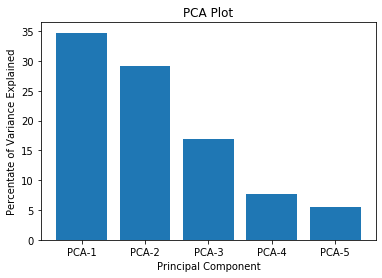

In [195]:
# Plot PCA
percent_variance = np.round(pca.explained_variance_ratio_ * 100, decimals=2)
columns = ['PCA-1', 'PCA-2', 'PCA-3', 'PCA-4','PCA-5']
plt.bar(x=range(1, 6), height=percent_variance, tick_label=columns)
plt.ylabel('Percentate of Variance Explained')
plt.xlabel('Principal Component')
plt.title('PCA Plot')
plt.show()

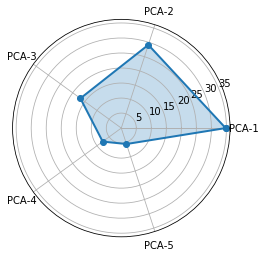

In [196]:
# spyder chart
angles=np.linspace(0, 2*np.pi, len(columns), endpoint=False)
# close the plot
stats=np.concatenate((percent_variance,[percent_variance[0]]))
angles=np.concatenate((angles,[angles[0]]))
fig=plt.figure()
ax = fig.add_subplot(111, polar=True)
ax.plot(angles, stats, 'o-', linewidth=2)
ax.fill(angles, stats, alpha=0.25)
ax.set_thetagrids(angles * 180/np.pi, columns)
#ax.set_title([df.loc[386,"Name"]])
ax.grid(True)